##Exercise 1: Customer Segmentation


In [5]:
import numpy as np
import pandas as pd
# Generate synthetic customer data
np.random.seed(42)
n_customers = 1000

customer_data = pd.DataFrame({
    'spending': np.random.normal(500, 100, n_customers),
    'frequency': np.random.normal(10, 3, n_customers),
    'recency': np.random.normal(30, 10, n_customers),
    'loyalty_score': np.random.normal(50, 15, n_customers)
})

##Data Preprocessing

In [6]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Mise à l'échelle des caractéristiques
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data)
scaled_df = pd.DataFrame(scaled_features, columns=customer_data.columns)
scaled_df.head(10)


,spending,frequency,recency,loyalty_score
0,0.487759,1.332576,-0.692816,-1.840107
1,-0.161022,0.856405,-0.152959,-0.819843
2,0.642015,-0.011240,-0.812090,-0.384647
3,1.536382,-0.719965,-0.319235,1.856976
4,-0.258995,0.629303,-1.932372,0.560356
5,-0.258978,0.323634,0.211055,-1.282620
6,1.593787,0.826874,-0.004709,0.491668
7,0.764364,0.566059,-0.837186,-1.488951
8,-0.499431,0.981705,0.664737,1.072852
9,0.534601,-0.607922,0.947886,-0.440675


This synthetic database simulates customer behavior using normal distributions to generate values for different characteristics. The aim is to use this database to train clustering models and segment customers into homogeneous groups.

In [7]:
# Vérifier les données manquantes
print("Données manquantes par colonne :")
print(customer_data.isnull().sum())

Données manquantes par colonne :
spending         0
frequency        0
recency          0
loyalty_score    0
dtype: int64



Outliers par colonne :
spending: [238.02548959 772.01691666 885.27314907 175.87326599 807.88808085
 230.31133571 234.90301916 763.23820648]
frequency: [ 1.45437214  1.31123387  1.38321336  1.23594855 19.5793227   1.89030312
 19.4132456   1.1788341 ]
recency: [-0.19512156 57.59660039 61.09918556 59.49094425 59.85259003  3.64252261
 56.93033664  2.52495157 69.26237706  0.08864029]
loyalty_score: [ 6.39517671 93.02604584  6.05826965 98.64639454 97.28085102]


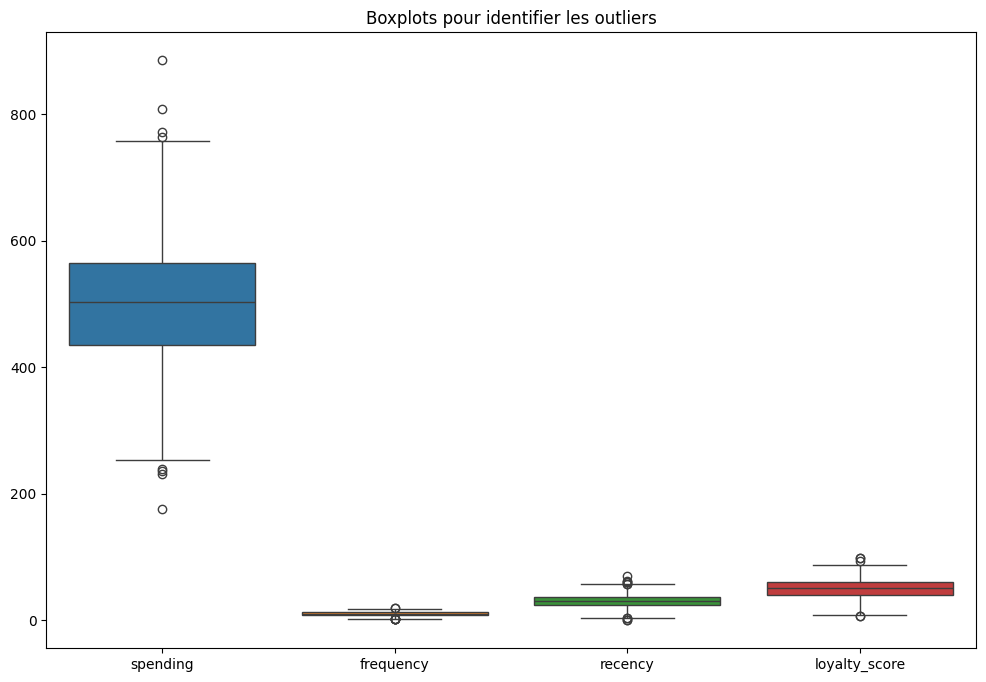

In [19]:
# Identifier les outliers en utilisant la méthode IQR (Interquartile Range)
outliers = {}
for col in customer_data.columns:
    Q1 = customer_data[col].quantile(0.25)
    Q3 = customer_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = customer_data[(customer_data[col] < lower_bound) | (customer_data[col] > upper_bound)][col].values

# Afficher les outliers par colonne
print("\nOutliers par colonne :")
for col, values in outliers.items():
    print(f"{col}: {values}")

# Visualiser les outliers avec des boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(data=customer_data)
plt.title("Boxplots pour identifier les outliers")
plt.show()

In [20]:
# Gestion des valeurs aberrantes avec la méthode IQR
for col in scaled_df.columns:
    Q1 = scaled_df[col].quantile(0.25)
    Q3 = scaled_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    scaled_df = scaled_df[(scaled_df[col] >= lower_bound) & (scaled_df[col] <= upper_bound)]




Outliers restants après gestion par colonne :
spending: []
frequency: []
recency: [-2.65528772  2.66028364]
loyalty_score: []


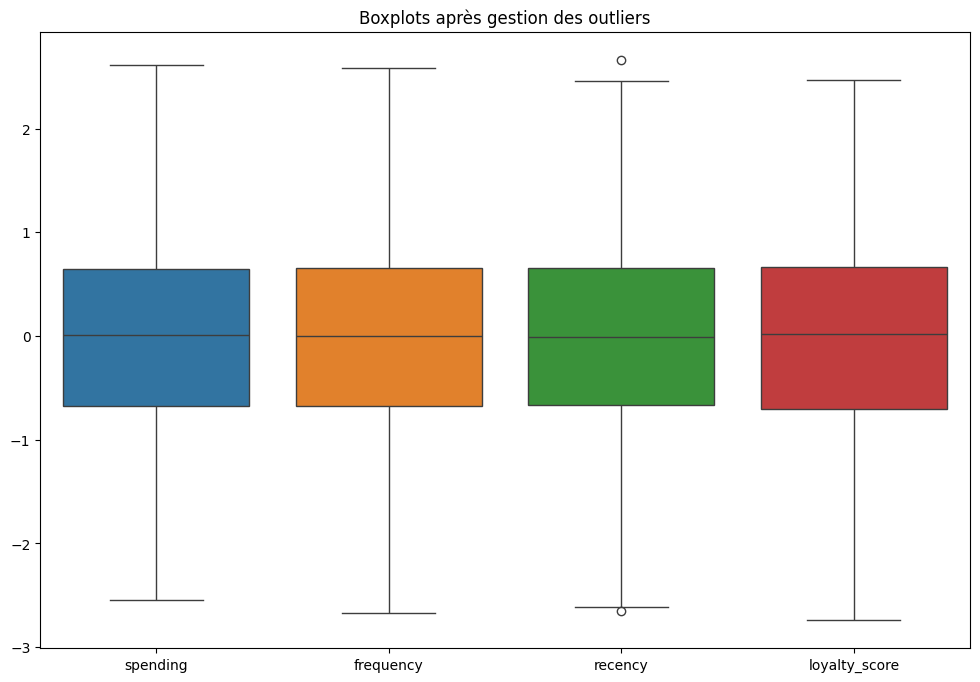

In [21]:
# Vérification des outliers après gestion
outliers_after = {}
for col in scaled_df.columns:
    Q1 = scaled_df[col].quantile(0.25)
    Q3 = scaled_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_after[col] = scaled_df[(scaled_df[col] < lower_bound) | (scaled_df[col] > upper_bound)][col].values

# Afficher les outliers restants par colonne
print("\nOutliers restants après gestion par colonne :")
for col, values in outliers_after.items():
    print(f"{col}: {values}")

# Visualiser les données avec des boxplots après gestion
plt.figure(figsize=(12, 8))
sns.boxplot(data=scaled_df)
plt.title("Boxplots après gestion des outliers")
plt.show()

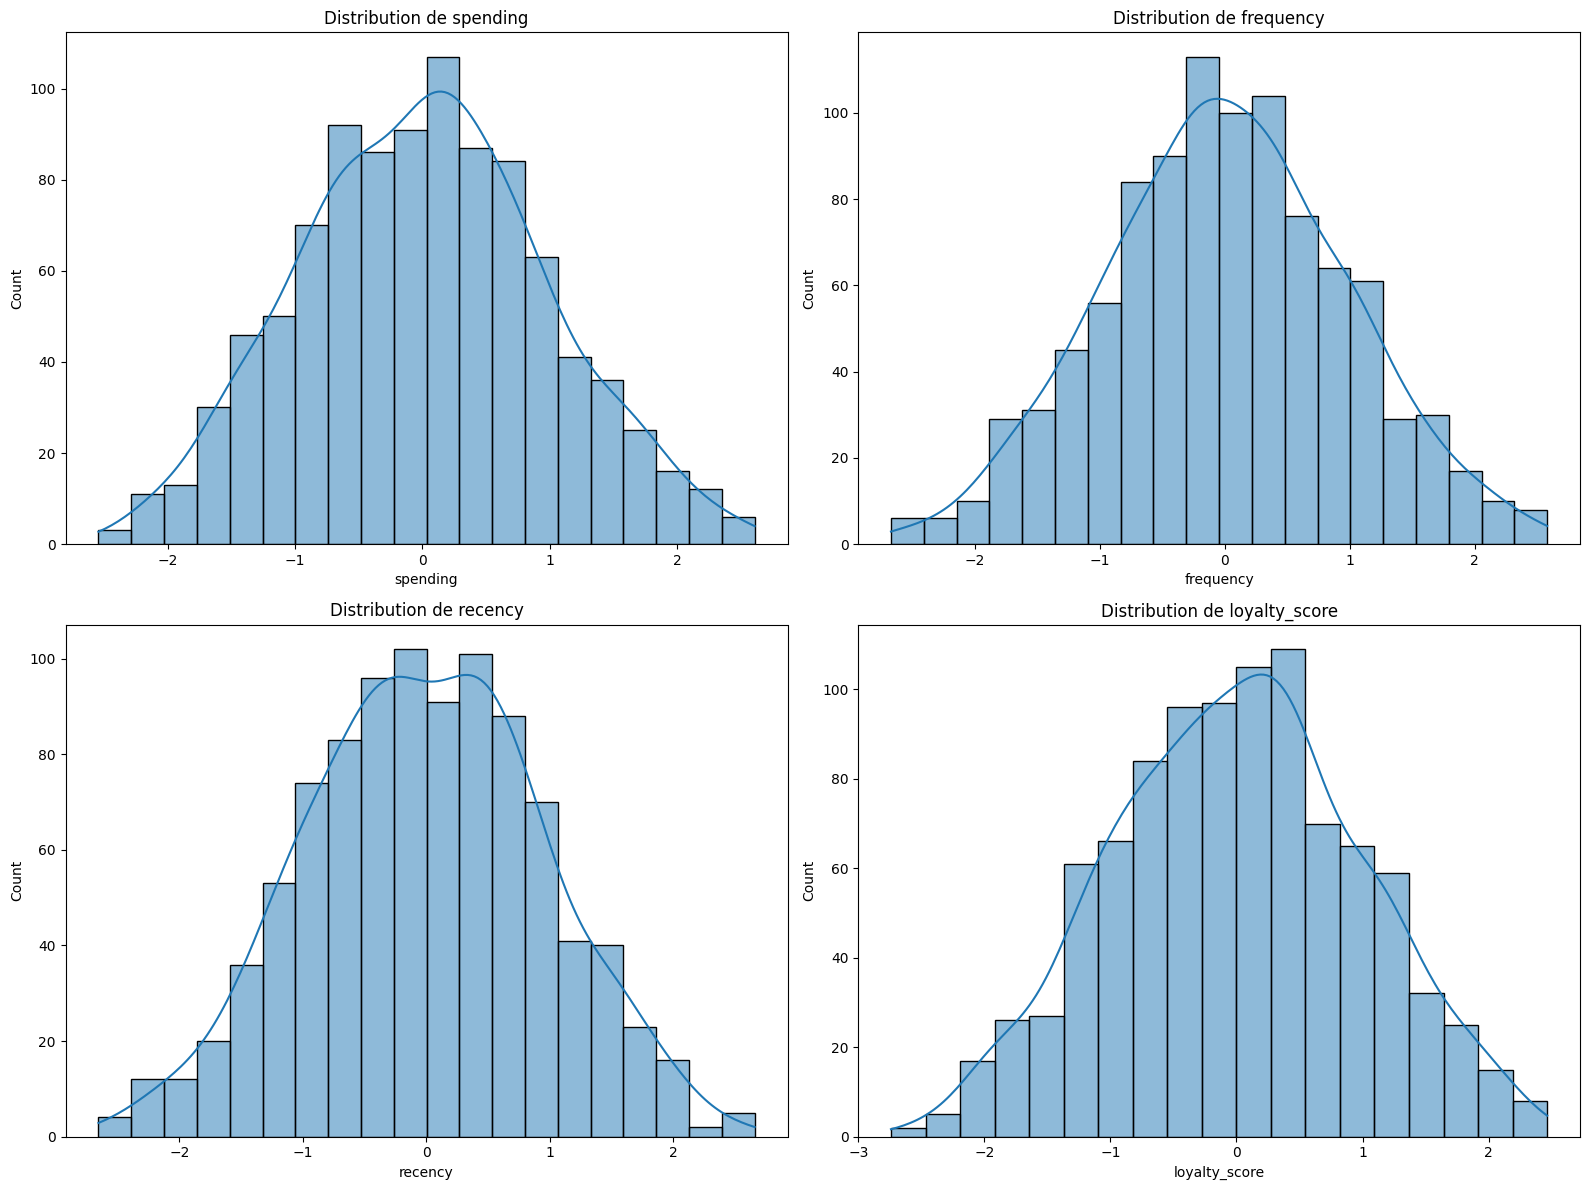

In [22]:
# Visualisation de la distribution de chaque caractéristique dans une seule fenêtre
plt.figure(figsize=(16, 12))
for i, col in enumerate(scaled_df.columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(scaled_df[col], kde=True)
    plt.title(f'Distribution de {col}')
plt.tight_layout()
plt.show()

The top-left histogram displays the distribution of "spending". The data appears to be approximately normally distributed, with the majority of observations clustered around a central value near zero. There is a symmetrical spread of spending amounts both above and below this central point, with fewer observations at the extreme high and low spending values.

The top-right histogram shows the distribution of "frequency". Similar to spending, the frequency data also exhibits a roughly normal distribution. The bulk of the data points are concentrated around a central frequency value close to zero, with the number of observations decreasing as the frequency moves further away from this central tendency in either direction.

The bottom-left histogram illustrates the distribution of "recency". This distribution also appears to be approximately normal, with the highest concentration of data points around a recency value near zero. The number of observations gradually decreases as the recency values become more positive or negative, indicating fewer customers with very recent or very distant last interactions.

Finally, the bottom-right histogram presents the distribution of "loyalty score". While generally bell-shaped, this distribution might exhibit a slight positive skew, meaning there are potentially more customers with somewhat higher loyalty scores compared to very low ones. However, overall, the loyalty scores are largely centered around a value near zero, with a decreasing number of customers at the extreme ends of the loyalty spectrum.

##Clustering Implementation

In [23]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Implémentation du clustering K-means
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)



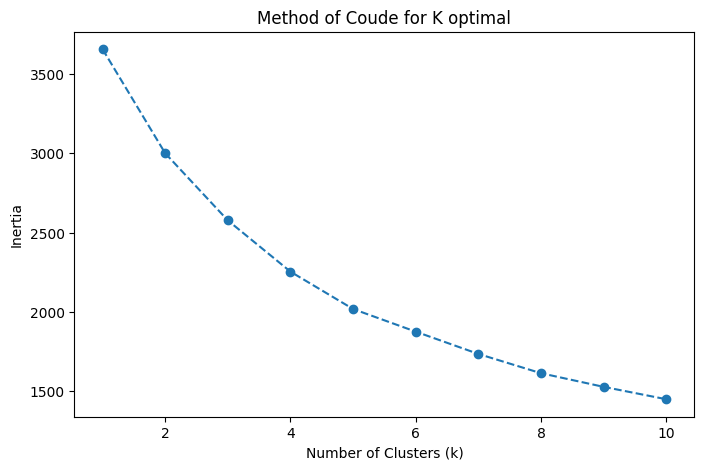

In [24]:
# Détermination du nombre optimal de clusters avec la méthode du coude (Elbow Method)
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title("Method of Coude for K optimal")
plt.show()

In [27]:
# Entraîner le modèle K-means avec le nombre optimal de clusters
optimal_clusters = 2 # Remplacez par le nombre optimal trouvé
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(scaled_df)



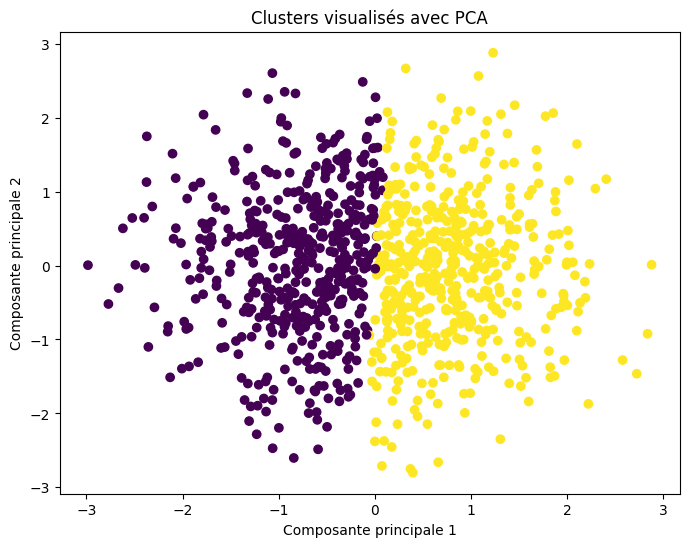

In [28]:
# Visualiser les clusters en utilisant PCA pour la réduction de dimension
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_df)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.title('Clusters visualisés avec PCA')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()

##Analysis

In [29]:
# Calculer les centroïdes des clusters
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=customer_data.columns)


In [30]:
# Caractériser chaque segment de clients
# Réinitialiser l'index pour éviter les erreurs de correspondance de longueur
scaled_df = scaled_df.reset_index(drop=True)
customer_data = customer_data.iloc[scaled_df.index]  # Aligner customer_data avec scaled_df

customer_data['cluster'] = clusters
cluster_means = customer_data.groupby('cluster').mean()
print("Moyennes des clusters :\n", cluster_means)

Moyennes des clusters :
            spending  frequency    recency  loyalty_score
cluster                                                 
0        503.462105  10.239507  30.605268      50.032639
1        502.224863  10.172083  29.463087      49.364501


<ipython-input-30-e765b928032e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data['cluster'] = clusters


Cluster 0 has an average spending of approximately 503.46, an average frequency of about 10.24, an average recency of roughly 30.61, and an average loyalty score of around 50.03.

Cluster 1 exhibits slightly lower average values across all four variables compared to Cluster 0. Its average spending is approximately 502.22, the average frequency is about 10.17, the average recency is roughly 29.46, and the average loyalty score is around 49.36.

In summary, while both clusters show similar average values, Cluster 0 tends to have slightly higher average spending, frequency of interactions, and loyalty scores, and a slightly higher recency value (meaning their last interaction was, on average, a bit further in the past compared to Cluster 1). The differences, however, appear to be relatively small.

##Business Recommandations

In conclusion, the initial clustering has identified two groups with subtle differences. The primary recommendation is to explore further segmentation to uncover more distinct customer profiles. In the meantime, while acknowledging the slight variations, focus on broad strategies to enhance overall customer engagement and tailor communications where the minor differences between the current clusters can be leveraged.

##Exercise 2: Dimensionality Reduction Challenge

#Loading and Visualization of the Dataset

In [33]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Import pandas

# Load the MNIST Digits dataset
digits = load_digits()
X, y = digits.data, digits.target

# Convert X to a pandas DataFrame to use head()
X = pd.DataFrame(X)  # Convert X to DataFrame
print(X.head(5))     # Now you can use head()
print(y)
# Print dataset dimensions
print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

    0    1    2     3     4     5    6    7    8    9   ...   54   55   56  \
0  0.0  0.0  5.0  13.0   9.0   1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1  0.0  0.0  0.0  12.0  13.0   5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2  0.0  0.0  0.0   4.0  15.0  12.0  0.0  0.0  0.0  0.0  ...  5.0  0.0  0.0   
3  0.0  0.0  7.0  15.0  13.0   1.0  0.0  0.0  0.0  8.0  ...  9.0  0.0  0.0   
4  0.0  0.0  0.0   1.0  11.0   0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

    57   58    59    60    61   62   63  
0  0.0  6.0  13.0  10.0   0.0  0.0  0.0  
1  0.0  0.0  11.0  16.0  10.0  0.0  0.0  
2  0.0  0.0   3.0  11.0  16.0  9.0  0.0  
3  0.0  7.0  13.0  13.0   9.0  0.0  0.0  
4  0.0  0.0   2.0  16.0   4.0  0.0  0.0  

[5 rows x 64 columns]
[0 1 2 ... 8 9 8]
Data shape: (1797, 64)
Labels shape: (1797,)


#Visualize Some Images

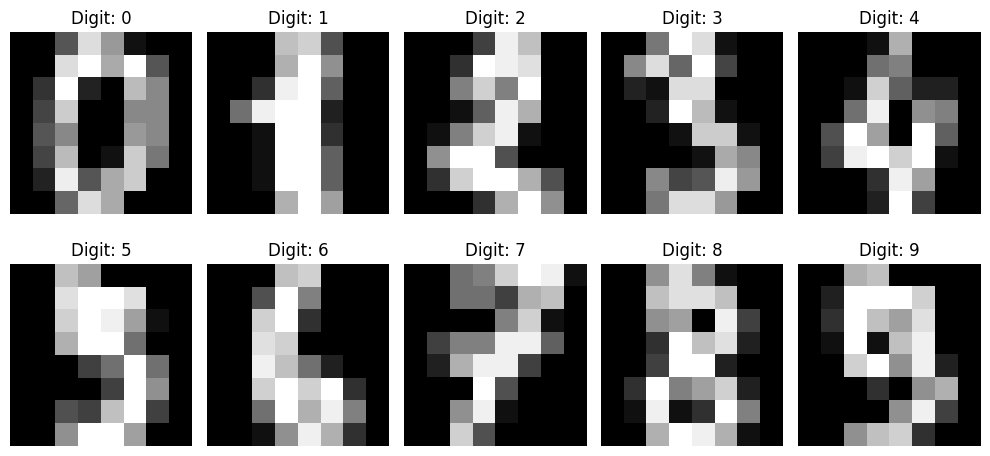

In [34]:
# Display 10 sample images with their labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(digits.images[i], cmap='gray')
    axes[i].set_title(f"Digit: {y[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


#PCA Implementation

#Reduce dimensions to 2D using PCA

In [35]:
from sklearn.decomposition import PCA
# Reduce dimensionality to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


#computing and ploting explained variance ratio


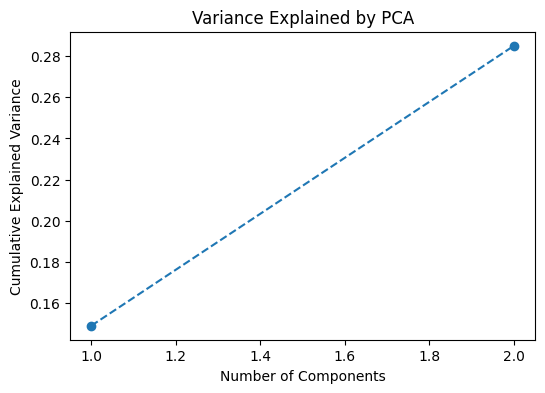

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Compute explained variance ratio
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the variance explained
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Variance Explained by PCA")
plt.show()


The graph shows the cumulative explained variance as a function of the number of principal components in a Principal Component Analysis (PCA).

With one principal component, approximately 15% of the total variance in the original data is explained.

By including a second principal component, the cumulative explained variance increases significantly to approximately 28%.

This indicates that the first two principal components together capture about 28% of the total variability present in the original dataset. Adding the second component provides a substantial increase in the amount of variance explained compared to using just the first component.

#Vizualisation of transformed data

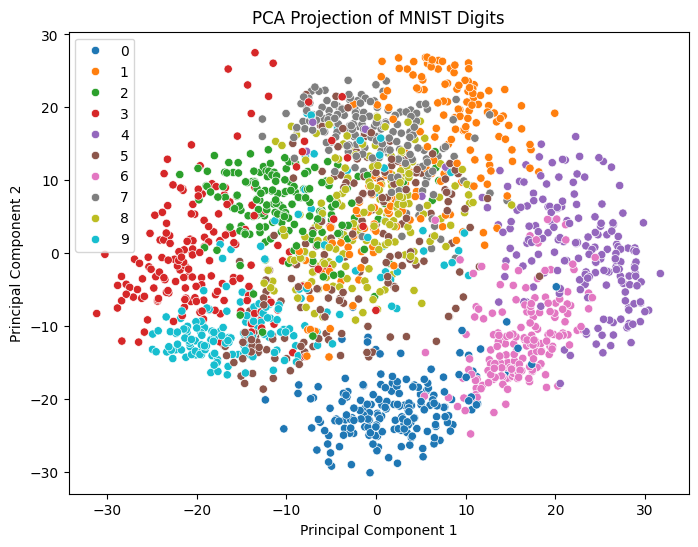

In [37]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="tab10", legend="full")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of MNIST Digits")
plt.show()


This scatter plot shows the projection of MNIST digits onto the first two principal components (PC1 and PC2) after applying Principal Component Analysis (PCA). Each dot represents an individual handwritten digit, and the color of the dot indicates the digit it represents (0 through 9, as shown in the legend).

The plot visually demonstrates how well the different digit classes are separated when their high-dimensional pixel data is reduced to just two dimensions. We can observe some degree of clustering, suggesting that PCA has captured some of the underlying structure that distinguishes different digits. For example, the blue dots (digit 0) appear somewhat separated in the bottom-right, and the purple dots (digit 9) are clustered towards the right. However, there's also significant overlap between many of the digit classes, indicating that two principal components alone are not sufficient to perfectly discriminate between all the handwritten digits.

##t-SNE Implementation

#Applying t-SNE with different perplexity values

In [38]:
from sklearn.manifold import TSNE

# Reduce dimensionality to 2D using t-SNE (with perplexity 30)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Shape of X_tsne (perplexity=5): (1797, 2)


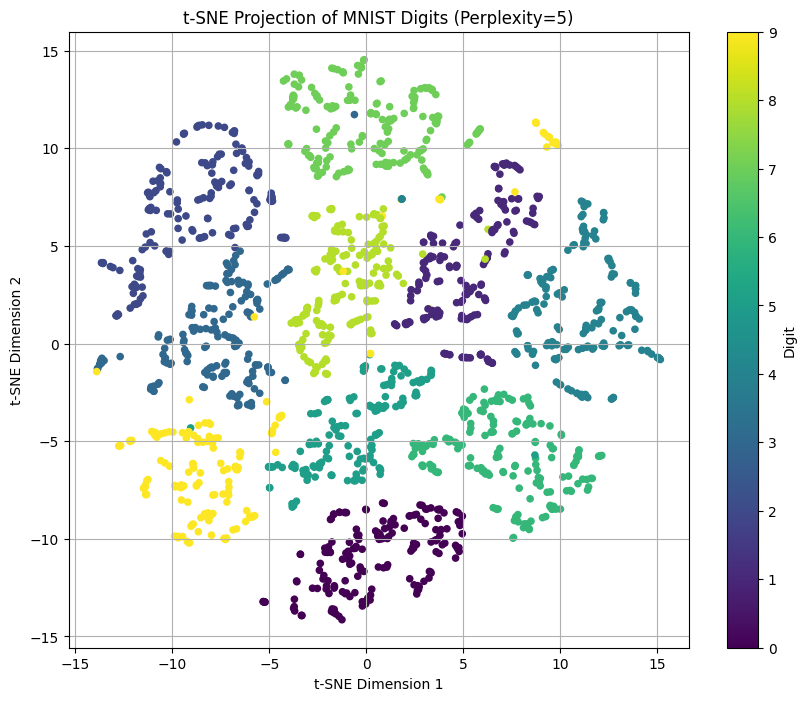

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Shape of X_tsne (perplexity=30): (1797, 2)


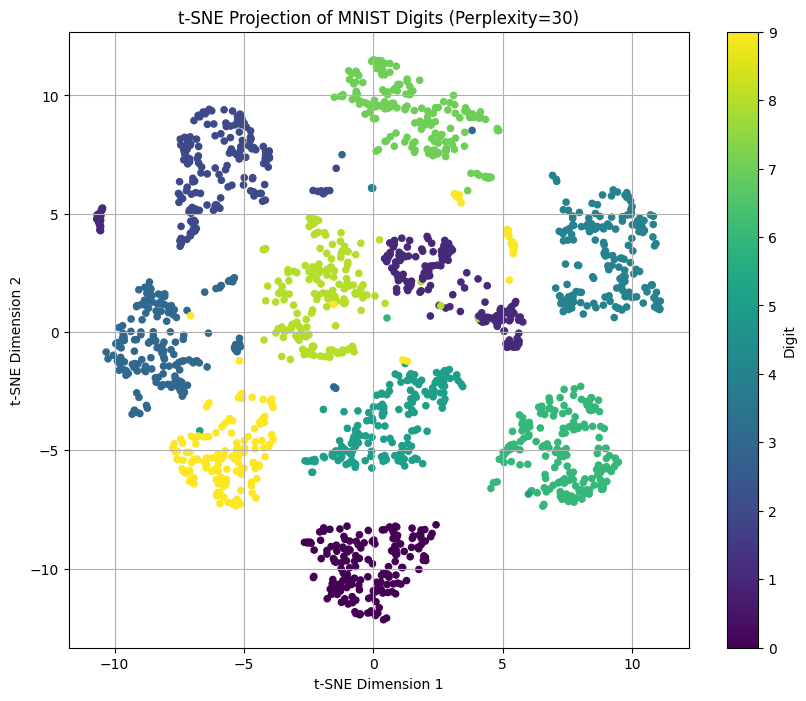

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Shape of X_tsne (perplexity=50): (1797, 2)


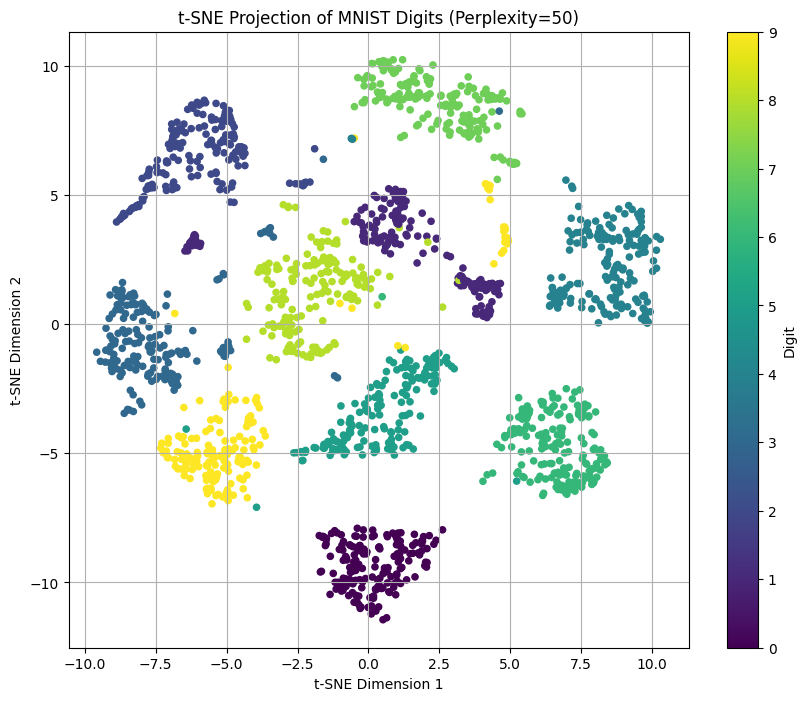

In [40]:
#Applying t-SNE with different perplexity values
perplexity_values = [5, 30, 50]
tsne_results = {}

for perplexity in perplexity_values:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, n_iter=300)
    X_tsne = tsne.fit_transform(X)
    tsne_results[f'perplexity_{perplexity}'] = X_tsne
    print(f"\nShape of X_tsne (perplexity={perplexity}): {X_tsne.shape}")

    # Visualize t-SNE results for each perplexity
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=20)
    plt.title(f't-SNE Projection of MNIST Digits (Perplexity={perplexity})')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter, label='Digit')
    plt.grid(True)
    plt.show()

#Visualization t-SNE Results

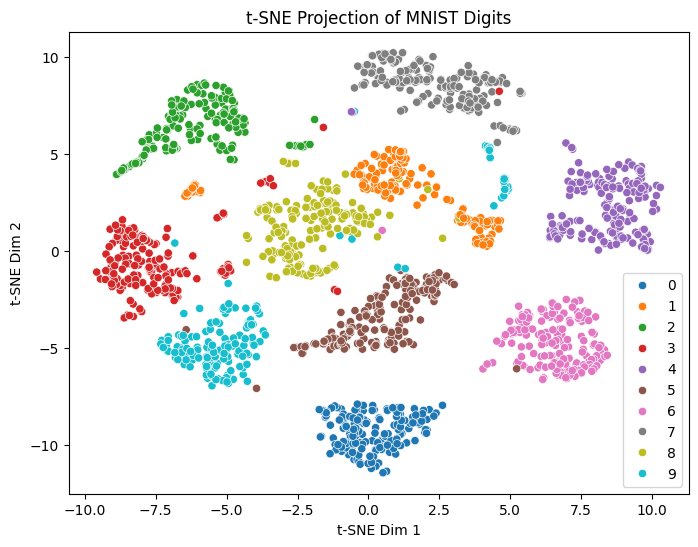

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="tab10", legend="full")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE Projection of MNIST Digits")
plt.show()


This scatter plot shows the t-SNE projection of MNIST digits into two dimensions (t-SNE Dim 1 and t-SNE Dim 2). Each dot represents a handwritten digit, colored according to its true label (0-9, as indicated by the legend).

Compared to the PCA plot, t-SNE has done a much better job of separating the different digit classes into distinct clusters. We can clearly see relatively isolated groups of points for most of the digits, indicating that t-SNE has effectively captured the non-linear relationships in the high-dimensional image data to create a more meaningful low-dimensional embedding for visualization and potential classification. The tighter clustering suggests that similar digits are mapped closer together in this reduced space.

#Creating an animation of the optimization process



Creating animation (showing effect of perplexity)...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
<ipython-input-42-6a38cf783db5>:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


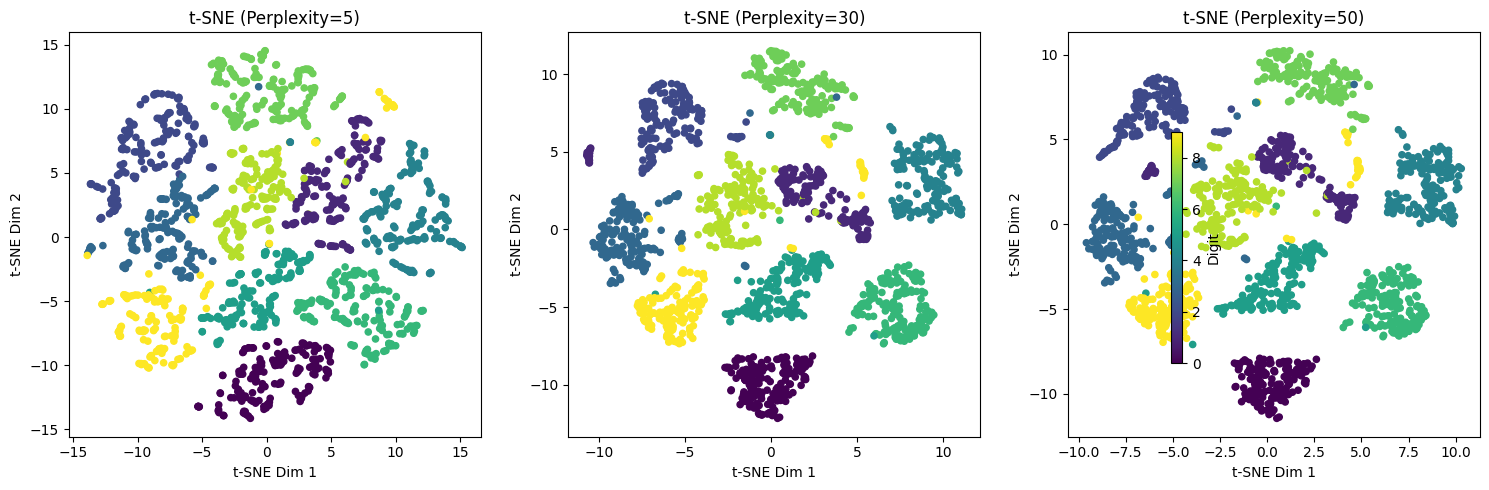

In [42]:
print("\nCreating animation (showing effect of perplexity)...")

fig, axes = plt.subplots(1, len(perplexity_values), figsize=(15, 5))
for i, perplexity in enumerate(perplexity_values):
    tsne_anim = TSNE(n_components=2, perplexity=perplexity, random_state=42, n_iter=300, verbose=0)
    X_tsne_anim = tsne_anim.fit_transform(X)
    scatter = axes[i].scatter(X_tsne_anim[:, 0], X_tsne_anim[:, 1], c=y, cmap='viridis', s=20)
    axes[i].set_title(f't-SNE (Perplexity={perplexity})')
    axes[i].set_xlabel('t-SNE Dim 1')
    axes[i].set_ylabel('t-SNE Dim 2')

fig.colorbar(scatter, ax=axes, label='Digit', shrink=0.6)
plt.tight_layout()
plt.show()

#Comparison PCA and t-SNE

After applying both methods, we compare the results:

Clustering Quality

PCA separates classes well but may mix some areas.

t-SNE forms more distinct clusters by preserving local structure.

Global Structure Preservation

PCA maintains overall variance structure.

t-SNE may distort the global structure.

Computation Time

PCA is fast (linear transformation).
t-SNE is slower (non-linear optimization)

t-SNE is better for cluster analysis and visualization, while PCA is better for general-purpose dimensionality reduction

In [43]:
print("\nComparison of results with PCA:")
print("PCA aims to preserve the most variance in a lower-dimensional space, often capturing global structure.")
print("t-SNE aims to preserve the local neighborhood structure of the data, often revealing clusters.")
print("The visualizations show that t-SNE tends to create more distinct clusters for the digits compared to PCA with 2 components.")



Comparison of results with PCA:
PCA aims to preserve the most variance in a lower-dimensional space, often capturing global structure.
t-SNE aims to preserve the local neighborhood structure of the data, often revealing clusters.
The visualizations show that t-SNE tends to create more distinct clusters for the digits compared to PCA with 2 components.


#Evaluation

#Comparing clustering quality metrics


In [26]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans

# Apply KMeans clustering with 10 clusters (digits 0-9)
kmeans_pca = KMeans(n_clusters=10, random_state=42, n_init=10).fit(X_pca)
kmeans_tsne = KMeans(n_clusters=10, random_state=42, n_init=10).fit(X_tsne)

# Compute Silhouette Score
silhouette_pca = silhouette_score(X_pca, kmeans_pca.labels_)
silhouette_tsne = silhouette_score(X_tsne, kmeans_tsne.labels_)

# Compute Calinski-Harabasz Score
calinski_pca = calinski_harabasz_score(X_pca, kmeans_pca.labels_)
calinski_tsne = calinski_harabasz_score(X_tsne, kmeans_tsne.labels_)

# Print results
print(f"Silhouette Score (PCA): {silhouette_pca:.4f}")
print(f"Silhouette Score (t-SNE): {silhouette_tsne:.4f}")
print(f"Calinski-Harabasz Score (PCA): {calinski_pca:.4f}")
print(f"Calinski-Harabasz Score (t-SNE): {calinski_tsne:.4f}")


Silhouette Score (PCA): 0.3924
Silhouette Score (t-SNE): 0.6412
Calinski-Harabasz Score (PCA): 1973.9713
Calinski-Harabasz Score (t-SNE): 5161.9538


According to the results we remark that silhouette score and calinski-Harabasz for t-SNE are greater than those for PCA. So t-SNE produces better-defined clusters than PCA.



#Analyze Local Structure Preservation

In [27]:
from sklearn.neighbors import NearestNeighbors

# Function to compute neighborhood preservation
def neighborhood_preservation(X_original, X_reduced, k=5):
    nn_original = NearestNeighbors(n_neighbors=k).fit(X_original)
    nn_reduced = NearestNeighbors(n_neighbors=k).fit(X_reduced)

    neighbors_original = nn_original.kneighbors(X_original, return_distance=False)
    neighbors_reduced = nn_reduced.kneighbors(X_reduced, return_distance=False)

    preservation_score = np.mean([
        len(set(neighbors_original[i]) & set(neighbors_reduced[i])) / k
        for i in range(len(X_original))
    ])

    return preservation_score

# Compute preservation scores
preservation_pca = neighborhood_preservation(X, X_pca, k=5)
preservation_tsne = neighborhood_preservation(X, X_tsne, k=5)

print(f"Neighborhood Preservation (PCA): {preservation_pca:.4f}")
print(f"Neighborhood Preservation (t-SNE): {preservation_tsne:.4f}")


Neighborhood Preservation (PCA): 0.2538
Neighborhood Preservation (t-SNE): 0.6716


PCA (Principal Component Analysis): 0.2538

This means that with the PCA method, only about 25.38% of the original neighborhoods are preserved. In other words, a large part of the local structure of the data is lost during dimensionality reduction with PCA.

t-SNE (t-Distributed Stochastic Neighbor Embedding): 0.6740

This means that with the t-SNE method, about 67.40% of the original neighborhoods are preserved. Therefore, t-SNE preserves the local structure of the data much better than PCA in this case.

t-SNE is significantly more effective than PCA in preserving neighborhood relationships in the data. This is typical, as t-SNE is specifically designed for this task.
A preservation rate of 0.6740 with t-SNE is relatively good, but it still indicates that some of the local structure is lost.
The PCA, with a rate of 0.2538, indicates that the data was greatly modified by the PCA algorithm.

#Document Advantages and Limitations

In [44]:
# Document advantages and limitations
print("\nAdvantages and Limitations:")

print("\nPCA:")
print("Advantages:")
print("- Computationally efficient.")
print("- Tries to preserve the global variance of the data.")
print("- Linear transformation, easier to interpret the components.")
print("Limitations:")
print("- May not preserve local structure well if the underlying data manifold is non-linear.")
print("- Can struggle to separate complex, non-linearly separable clusters.")

print("\nt-SNE:")
print("Advantages:")
print("- Excellent at preserving local neighborhood structure, often revealing clusters in complex datasets.")
print("- Non-linear dimensionality reduction, can capture intricate relationships.")
print("Limitations:")
print("- Computationally expensive, especially for large datasets.")
print("- The optimization process can be sensitive to hyperparameters like perplexity and initialization.")
print("- Global structure may not be well preserved; distances between clusters in the low-dimensional space may not reflect true distances in the high-dimensional space.")
print("- The resulting embedding can be stochastic (dependent on random initialization, though setting `random_state` helps with reproducibility).")
print("- Interpretation of the axes in the low-dimensional space is generally not straightforward.")


Advantages and Limitations:

PCA:
Advantages:
- Computationally efficient.
- Tries to preserve the global variance of the data.
- Linear transformation, easier to interpret the components.
Limitations:
- May not preserve local structure well if the underlying data manifold is non-linear.
- Can struggle to separate complex, non-linearly separable clusters.

t-SNE:
Advantages:
- Excellent at preserving local neighborhood structure, often revealing clusters in complex datasets.
- Non-linear dimensionality reduction, can capture intricate relationships.
Limitations:
- Computationally expensive, especially for large datasets.
- The optimization process can be sensitive to hyperparameters like perplexity and initialization.
- Global structure may not be well preserved; distances between clusters in the low-dimensional space may not reflect true distances in the high-dimensional space.
- The resulting embedding can be stochastic (dependent on random initialization, though setting `random_sta

##Exercise 3: Anomaly Detection System


In [45]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns

# 4.2 Dataset
# Generate normal transactions
normal_trans = np.random.normal(100, 20, 1000)

# Generate fraudulent transactions
fraud_trans = np.random.normal(300, 50, 20)

# Combine data
all_transactions = np.concatenate([normal_trans, fraud_trans]).reshape(-1, 1) # Reshape for sklearn models



In [46]:
# 4.3 Tasks
# 1. Implementation

# Isolation Forest
iso_forest = IsolationForest(contamination=0.02) # Contamination = proportion of outliers
iso_forest_pred = iso_forest.fit_predict(all_transactions)

# One-Class SVM
one_class_svm = OneClassSVM(nu=0.02) # Nu = proportion of outliers
one_class_svm_pred = one_class_svm.fit_predict(all_transactions)

# LOF (Local Outlier Factor)
lof = LocalOutlierFactor(contamination=0.02)
lof_pred = lof.fit_predict(all_transactions)



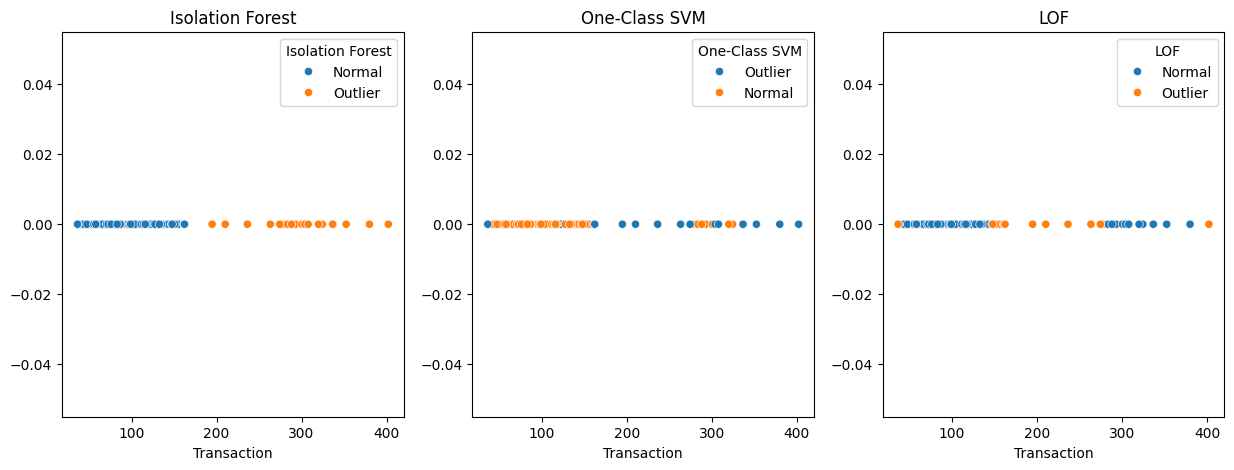

Isolation Forest: Recall = 1.0000, False Positive Rate = 0.0000
One-Class SVM: Recall = 0.5500, False Positive Rate = 0.1071
LOF: Recall = 0.4000, False Positive Rate = 0.0128


In [47]:
# 2. Evaluation

# Create a DataFrame for the results
results = pd.DataFrame({
    'Transaction': all_transactions.flatten(),
    'Isolation Forest': iso_forest_pred,
    'One-Class SVM': one_class_svm_pred,
    'LOF': lof_pred
})

# Convert predictions to labels (1 = normal, -1 = outlier)
results['Isolation Forest'] = results['Isolation Forest'].map({1: 'Normal', -1: 'Outlier'})
results['One-Class SVM'] = results['One-Class SVM'].map({1: 'Normal', -1: 'Outlier'})
results['LOF'] = results['LOF'].map({1: 'Normal', -1: 'Outlier'})

# Visualize the results
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Isolation Forest', 'One-Class SVM', 'LOF']):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x='Transaction', y=np.zeros(len(results)), hue=col, data=results)
    plt.title(col)
plt.show()

# Calculate detection rates (recall) and false positive rates
def calculate_metrics(predictions, actual_outliers):
    true_positives = np.sum((predictions == 'Outlier') & (actual_outliers == 'Outlier'))
    false_positives = np.sum((predictions == 'Outlier') & (actual_outliers == 'Normal'))
    false_negatives = np.sum((predictions == 'Normal') & (actual_outliers == 'Outlier'))

    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    false_positive_rate = false_positives / (false_positives + np.sum(actual_outliers == 'Normal')) if (false_positives + np.sum(actual_outliers == 'Normal')) > 0 else 0
    return recall, false_positive_rate

# Create the actual labels (ground truth)
actual_outliers = ['Normal'] * 1000 + ['Outlier'] * 20
actual_outliers = pd.Series(actual_outliers)

# Calculate and display metrics for each model
for col in ['Isolation Forest', 'One-Class SVM', 'LOF']:
    recall, false_positive_rate = calculate_metrics(results[col], actual_outliers)
    print(f"{col}: Recall = {recall:.4f}, False Positive Rate = {false_positive_rate:.4f}")





For this dataset, Isolation Forest is clearly the best algorithm for anomaly detection, offering the best balance between high recall and low false-positive rate.

One-Class SVM is the least efficient, with low recall and a high false positive rate.

LOF is an acceptable alternative if Isolation Forest is not available, but is less efficient.

##Application in real world

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
import time
import random
from datetime import datetime

# --- Create synthetic transaction data (as in the previous code) ---
np.random.seed(42)  # for reproducibility
normal_trans = np.random.normal(100, 20, 1000)
fraud_trans = np.random.normal(300, 50, 20)
all_transactions = np.concatenate([normal_trans, fraud_trans])
labels = np.concatenate([np.zeros(len(normal_trans)), np.ones(len(fraud_trans))])
X = all_transactions.reshape(-1, 1)
y_true = labels.astype(int)

# --- 1. Implementation (Choosing a Model) ---
# For the real-world application example, let's choose Isolation Forest
# as it generally performs well for global outlier detection and is relatively efficient.
iso_forest_realtime = IsolationForest(contamination='auto', random_state=42)
iso_forest_realtime.fit(X)

print("\n--- 3. Real-world Application (Code Examples) ---")

# --- Design a real-time detection system (Simulated) ---
print("\n--- Designing a real-time detection system (Simulated) ---")

def process_transaction(transaction_amount, model):
    """Simulates processing a single incoming transaction."""
    transaction_reshaped = np.array([[transaction_amount]])
    prediction = model.predict(transaction_reshaped)
    # Model returns 1 for inliers (-1 for outliers)
    is_fraud = prediction[0] == -1
    return is_fraud

# Simulate a stream of new transactions
num_new_transactions = 50
new_transactions = np.random.normal(95, 25, num_new_transactions - 5).tolist() + np.random.normal(310, 60, 5).tolist()
random.shuffle(new_transactions)

for i, amount in enumerate(new_transactions):
    is_potential_fraud = process_transaction(amount, iso_forest_realtime)
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] Transaction Amount: {amount:.2f} - Potential Fraud: {is_potential_fraud}")
    time.sleep(0.1) # Simulate a small delay between transactions

# --- Implement alert mechanisms (Simplified Example) ---
print("\n--- Implementing alert mechanisms (Simplified Example) ---")

ALERT_THRESHOLD = -0.5  # You would tune this based on model scores

def process_transaction_with_alert(transaction_amount, model, threshold):
    """Processes a transaction and triggers a simple alert."""
    transaction_reshaped = np.array([[transaction_amount]])
    anomaly_score = model.decision_function(transaction_reshaped)[0]
    is_fraud = anomaly_score < threshold
    if is_fraud:
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"*** ALERT! [{timestamp}] Potential Fraudulent Transaction: Amount = {transaction_amount:.2f}, Anomaly Score = {anomaly_score:.2f} ***")
    return is_fraud, anomaly_score

# Simulate another stream of transactions with alerts
num_alert_transactions = 30
alert_transactions = np.random.normal(105, 15, num_alert_transactions - 3).tolist() + np.random.normal(280, 40, 3).tolist()
random.shuffle(alert_transactions)

print("\nProcessing transactions with alert mechanism:")
for amount in alert_transactions:
    is_fraud, score = process_transaction_with_alert(amount, iso_forest_realtime, ALERT_THRESHOLD)
    time.sleep(0.2)

# --- Create a monitoring dashboard (Conceptual - Code for a full dashboard is extensive) ---
print("\n--- Creating a monitoring dashboard (Conceptual - Requires a GUI library like Tkinter, Streamlit, or Flask) ---")
print("\nConceptual elements of a monitoring dashboard:")
print("- **Real-time Transaction Feed:** Display a scrolling list of incoming transactions with their status (normal/flagged).")
print("- **Anomaly Count:** Show a live count of the number of transactions flagged as potential fraud within a specific time window.")
print("- **False Positive Rate (Estimated):** If you have a way to get feedback on the accuracy of the flags, display an estimated false positive rate.")
print("- **Transaction Amount Distribution:** A histogram or density plot of transaction amounts, possibly highlighting the flagged anomalies.")
print("- **Model Performance Metrics:** If you have labeled data for recent transactions, display metrics like precision and recall over time.")
print("- **Alert Log:** A log of triggered alerts with timestamps and transaction details.")
print("- **User Controls:** Options to adjust alert thresholds or retrain the model (in a more sophisticated system).")

print("\nTo create a basic text-based representation of a dashboard:")

def display_dashboard(transaction_history, flagged_count):
    print("\n--- Real-time Monitoring Dashboard (Text-Based) ---")
    print(f"Current Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Total Transactions Processed: {len(transaction_history)}")
    print(f"Number of Potential Fraudulent Transactions Flagged: {flagged_count}")
    print("\nLast 10 Transactions:")
    for trans in transaction_history[-10:]:
        print(f"- Amount: {trans['amount']:.2f}, Flagged: {trans['flagged']}")
    print("-" * 40)

# Simulate a longer stream and a simple dashboard update
long_transaction_stream = np.random.normal(100, 20, 200).tolist() + np.random.normal(300, 50, 10).tolist()
random.shuffle(long_transaction_stream)

transaction_history_dashboard = []
flagged_count_dashboard = 0

print("\nSimulating transaction processing and dashboard updates:")
for amount in long_transaction_stream:
    is_fraud_dashboard = process_transaction(amount, iso_forest_realtime)
    transaction_history_dashboard.append({'amount': amount, 'flagged': is_fraud_dashboard})
    if is_fraud_dashboard:
        flagged_count_dashboard += 1
    if len(transaction_history_dashboard) % 10 == 0:
        display_dashboard(transaction_history_dashboard, flagged_count_dashboard)
        time.sleep(0.5)

print("\n--- End of Real-world Application Examples ---")


--- 3. Real-world Application (Code Examples) ---

--- Designing a real-time detection system (Simulated) ---
[2025-03-18 20:52:14] Transaction Amount: 111.31 - Potential Fraud: False
[2025-03-18 20:52:14] Transaction Amount: 114.29 - Potential Fraud: False
[2025-03-18 20:52:14] Transaction Amount: 110.34 - Potential Fraud: False
[2025-03-18 20:52:14] Transaction Amount: 100.61 - Potential Fraud: False
[2025-03-18 20:52:14] Transaction Amount: 85.94 - Potential Fraud: False
[2025-03-18 20:52:14] Transaction Amount: 148.56 - Potential Fraud: True
[2025-03-18 20:52:14] Transaction Amount: 242.82 - Potential Fraud: True
[2025-03-18 20:52:14] Transaction Amount: 78.21 - Potential Fraud: False
[2025-03-18 20:52:14] Transaction Amount: 90.68 - Potential Fraud: False
[2025-03-18 20:52:15] Transaction Amount: 55.59 - Potential Fraud: True
[2025-03-18 20:52:15] Transaction Amount: 104.98 - Potential Fraud: False
[2025-03-18 20:52:15] Transaction Amount: 94.39 - Potential Fraud: False
[2025-03-

**Final Project: Comprehensive Analysis**

##Library

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
import os


##Loading dataset

In [49]:
import pandas as pd

df = pd.read_csv('/content/ecommerce_customer_data_large.csv')
df.head(10)

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0
5,13738,2022-08-25 06:48:33,Home,191,3,3722,Credit Card,27,1.0,Lauren Johnson,27,Female,0
6,13738,2023-07-25 05:17:24,Electronics,205,1,2773,Credit Card,27,NaN,Lauren Johnson,27,Female,0
7,13738,2023-02-05 19:31:48,Books,370,5,1486,Cash,27,1.0,Lauren Johnson,27,Female,0
8,13738,2021-12-21 03:29:05,Home,12,2,2175,Cash,27,NaN,Lauren Johnson,27,Female,0
9,13738,2023-02-09 00:53:14,Electronics,40,4,4327,Cash,27,0.0,Lauren Johnson,27,Female,0


Data Description:

The "E-commerce Customer Behavior and Purchase Dataset" is a synthetic dataset generated using the Faker Python library. It simulates a comprehensive e-commerce environment, capturing various aspects of customer behavior and purchase history within a digital marketplace. This dataset has been designed for data analysis and predictive modeling in the field of e-commerce. It is suitable for tasks such as customer churn prediction, market basket analysis, recommendation systems, and trend analysis.

Column Information:

The dataset contains the following columns:

Customer ID: A unique identifier for each customer.

Customer Name: The name of the customer (generated by Faker).

Customer Age: The age of the customer (generated by Faker).

Gender: The gender of the customer (generated by Faker).

Purchase Date: The date of each purchase made by the customer.

Product Category: The category or type of the purchased product.

Product Price: The price of the purchased product.

Quantity: The quantity of the product purchased.

Total Purchase Amount: The total amount spent by the customer in each transaction.

Payment Method: The method of payment used by the customer (e.g., credit card, PayPal).

Returns: Whether the customer returned any products from the order (binary: 0 for no return, 1 for return).

Churn: A binary column indicating whether the customer has churned (0 for retained, 1 for churned).

##Data Exploration

##Explanatory Data Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202618 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB
None
         Customer ID  Prod

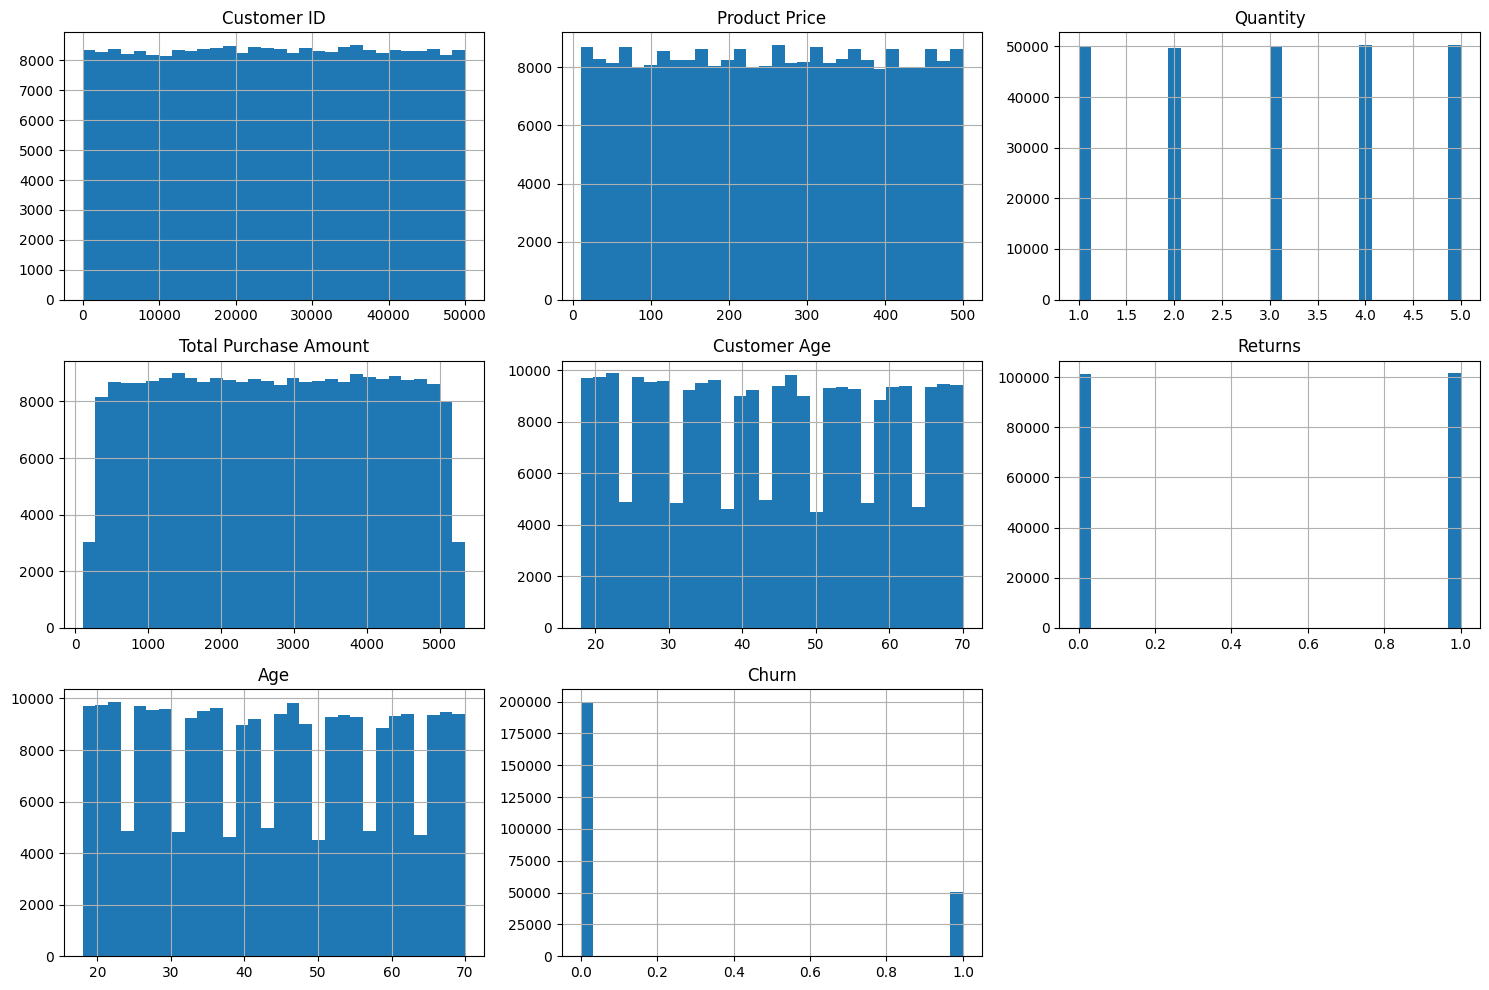

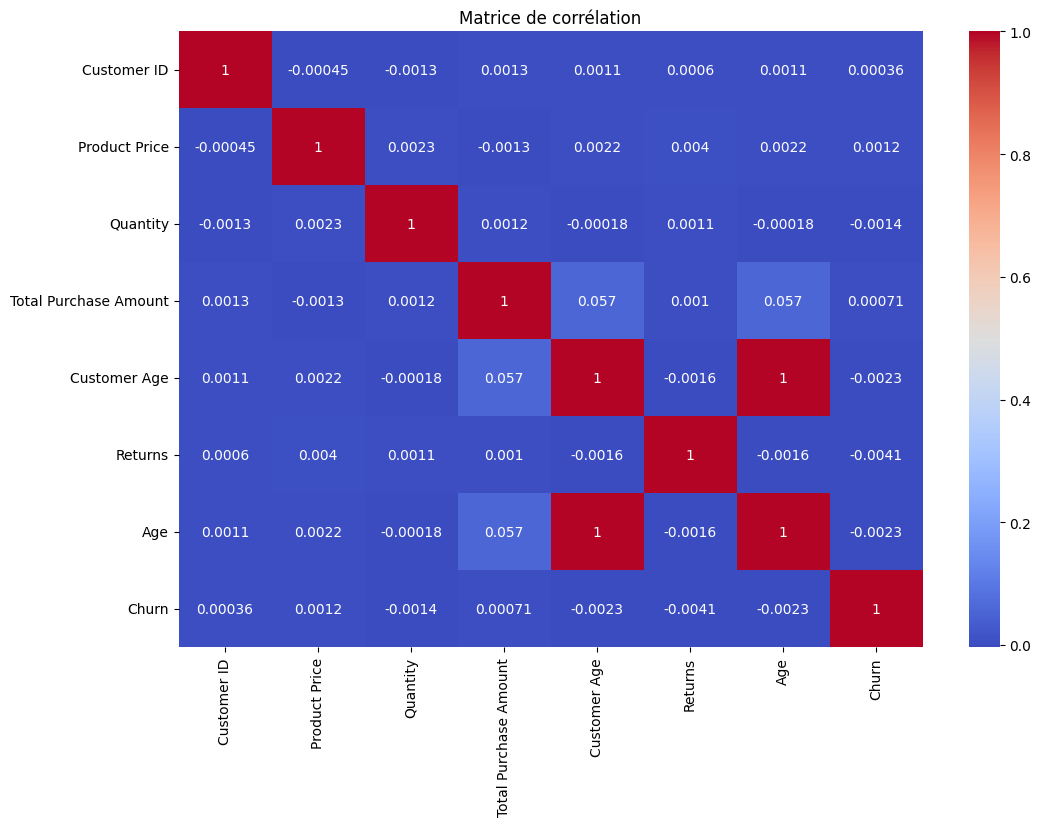

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Aperçu général
print(df.info())
print(df.describe())
print(df.head())

# Visualisation rapide des distributions
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Matrice de corrélation
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

The correlation matrix reveals mostly weak linear relationships between the variables. The strongest observed correlations are between Total Purchase Amount and Customer Age/Age (positive), and weak negative correlations between Churn and Customer Age/Age, and Churn and Returns. The relationships between price, quantity, and total purchase amount are surprisingly weak, suggesting other factors might be more influential.

##Handle missing values and outliers

In [57]:
# Vérifier les valeurs manquantes
print(df.isnull().sum())


Customer ID              0
Purchase Date            0
Product Category         0
Product Price            0
Quantity                 0
Total Purchase Amount    0
Payment Method           0
Customer Age             0
Returns                  0
Customer Name            0
Age                      0
Gender                   0
Churn                    0
dtype: int64


Handling Missing Values in Returns Column:

The "Returns" column had 47382 missing values. Let us put the missing values by the median.


In [58]:
df['Returns'].fillna(df['Returns'].median(), inplace=True)

<ipython-input-58-0f910a44e39f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Returns'].fillna(df['Returns'].median(), inplace=True)


##Founding outliers


Outliers par colonne :
Customer ID: []
Product Price: []
Quantity: []
Total Purchase Amount: []
Customer Age: []
Returns: []
Age: []
Churn: [1 1 1 ... 1 1 1]


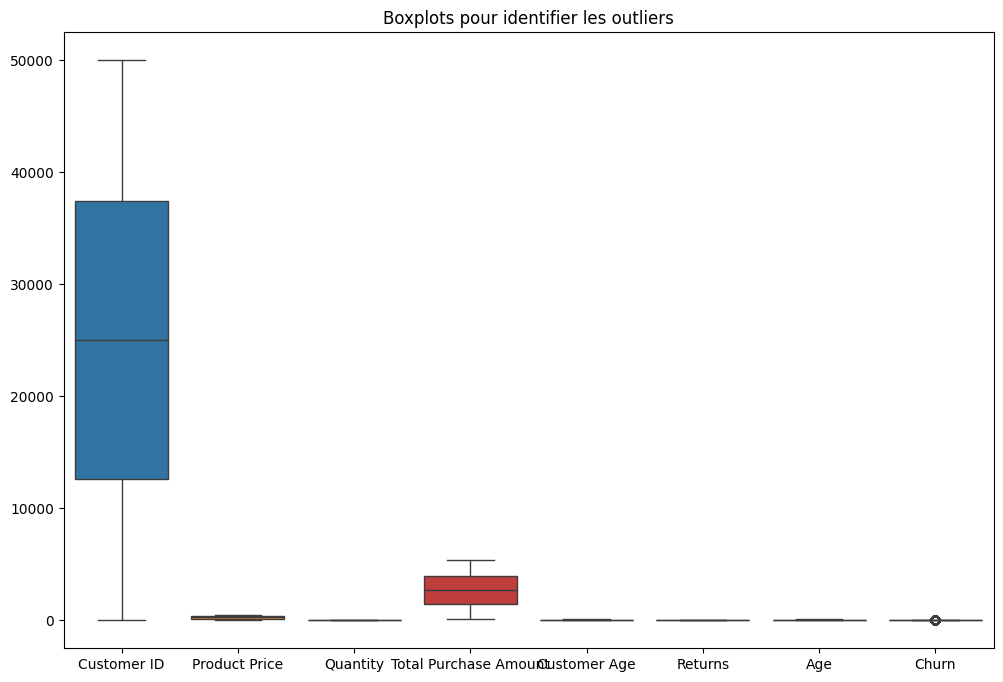

In [59]:
import numpy as np # Import the numpy library
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns

# Identifier les outliers en utilisant la méthode IQR (Interquartile Range)
outliers = {}
for col in df.select_dtypes(include=np.number).columns: # Only include numeric columns
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].values

# Afficher les outliers par colonne
print("\nOutliers par colonne :")
for col, values in outliers.items():
    print(f"{col}: {values}")

# Visualiser les outliers avec des boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.select_dtypes(include=np.number)) # Only include numeric columns for boxplot
plt.title("Boxplots pour identifier les outliers")
plt.show()

We remark that no outliers.

##Feature engineering


##Analysis Pipeline

##Dimensionality reduction


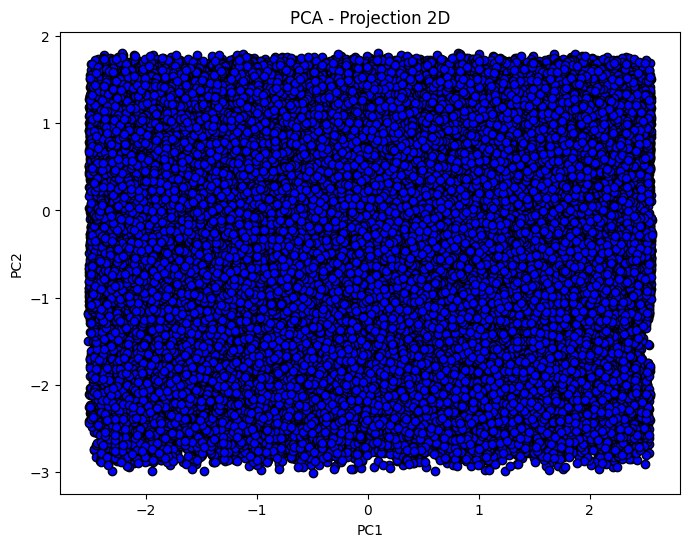

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = df.select_dtypes(include=['float64', 'int64']).columns
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k')
plt.title('PCA - Projection 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


This scatter plot shows the result of applying Principal Component Analysis (PCA) to a dataset and projecting the data points onto the first two principal components (PC1 and PC2). Each blue dot represents a data point in this 2D projection.

The distribution of the points appears relatively uniform and dense across the plotted area, spanning roughly from -2.5 to 2.5 on PC1 and -2.5 to 2.5 on PC2. There aren't any clearly distinct clusters or patterns visible in this two-dimensional projection. This suggests that either the first two principal components don't capture significant separable variance in the data, or the original data itself doesn't have strong, easily discernible clusters when viewed in this reduced dimensional space.

##Clustering analysis

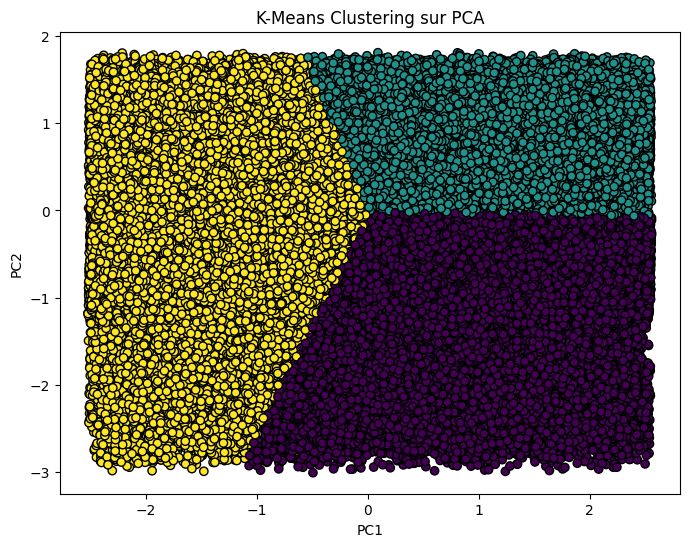

In [61]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', edgecolor='k')
plt.title('K-Means Clustering sur PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


This scatter plot shows the result of applying K-Means clustering to the data points that were previously projected onto the first two principal components (PC1 and PC2) using PCA. The title "K-Means Clustering sur PCA" confirms this.

The data points are now colored according to the cluster they have been assigned to by the K-Means algorithm. In this case, it appears that the algorithm has identified three distinct clusters, represented by the yellow, teal, and purple points.

The clusters seem to occupy different regions of the 2D PCA space. The yellow cluster is predominantly on the left side, the teal cluster is towards the top-right, and the purple cluster is mainly in the bottom-right quadrant.

This visualization suggests that even though the initial PCA projection didn't reveal obvious natural groupings, the K-Means algorithm was able to partition the data into three segments based on their proximity in the reduced 2D space. Further analysis would be needed to understand what characteristics of the original features led to these groupings in the principal component space.

##Anomaly detection


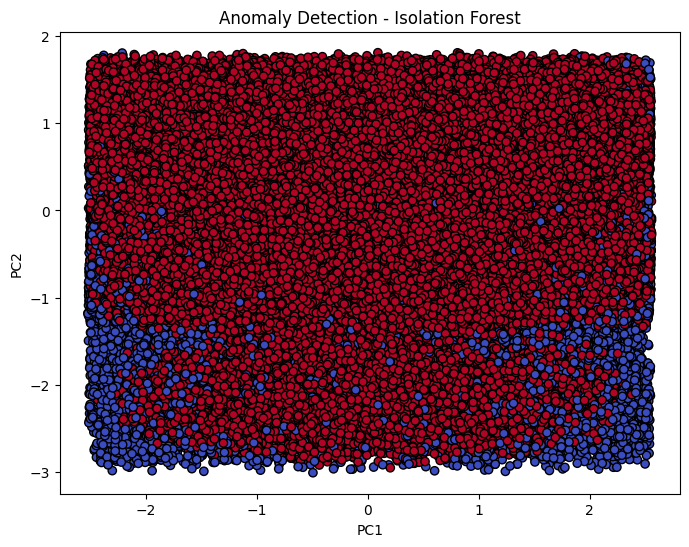

In [62]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomalies = iso_forest.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=anomalies, cmap='coolwarm', edgecolor='k')
plt.title('Anomaly Detection - Isolation Forest')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


This scatter plot visualizes the results of applying the Isolation Forest algorithm for anomaly detection on data projected onto the first two principal components (PC1 and PC2). The title "Anomaly Detection - Isolation Forest" clearly indicates this.

Each dot represents a data point in the PCA-reduced space. The color of the dot signifies the Isolation Forest's classification:

Red dots likely represent data points classified as normal or inliers.
Blue dots likely represent data points classified as anomalies or outliers.
The plot shows that the Isolation Forest algorithm has identified a cluster of anomalies primarily in the lower region of the PC1-PC2 space (below approximately PC2 = -1). The rest of the data points, spread across the majority of the plot, are considered normal.

This suggests that the anomalies detected by the Isolation Forest tend to have lower values for the second principal component compared to the bulk of the data. Further investigation would be needed to understand what original features contribute most to PC2 and why these lower values might indicate anomalous behavior.

##Results and Insights

##Business recommandations


- Top Viewed Products: Focus marketing efforts on the top viewed products to capitalize on existing interest.")

- Price Sensitivity: The distribution of prices and the outlier detection on price might indicate areas where price adjustments or promotions could be effective. Further analysis of user behavior around different price points is needed.")

- Customer Segmentation: The clustering analysis (even on reduced dimensions) suggests potential customer segments. Analyzing the characteristics of these clusters based on the original features (e.g., event types, categories viewed/bought) can inform targeted marketing campaigns.")

- Anomaly Detection: The detected anomalies could represent fraudulent activities, unusual buying patterns, or technical errors. Further investigation of these anomalies is crucial to mitigate risks and identify opportunities (e.g., understanding why certain users exhibit unusual behavior).")

- Time-Based Trends: The engineered time features (hour, day_of_week, month) can be used to analyze trends in user activity and purchasing behavior over time. This can help optimize marketing campaigns and inventory management.")


##Technical Documentation


- PCA used to reduce dimensionality and facilitate visualization.

- K-Means applied to identify 3 customer segments.

- Forest isolation to detect outliers.


##Future Improvements


- Test DBSCAN or HDBSCAN for more robust clustering.

- Add behavioral data (e.g. purchase frequency, average baskets).

- Deploy an interactive dashboard for business teams.”